In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
def detect_missing_data_type(df):
    """
    Detects missing data type (MCAR, MAR, MNAR) without using Logistic Regression.
    """
    print("\n========== Step 1: Visualizing Missing Data ==========\n")
    msno.matrix(df)
    msno.heatmap(df)

    print("\n========== Step 2: Performing Little’s MCAR Test ==========\n")
    try:
        from sklearn.impute import SimpleImputer
        df_encoded = df.copy()
        for col in df_encoded.select_dtypes(include=['object']).columns:
            df_encoded[col] = df_encoded[col].astype('category').cat.codes
        
        imputer = SimpleImputer(strategy="mean")
        df_imputed = imputer.fit_transform(df_encoded)
        
        s_complete = np.cov(df_imputed, rowvar=False)
        s_missing = np.cov(df_encoded.dropna(), rowvar=False)
        
        chi_square_stat = np.sum((s_complete - s_missing) ** 2 / s_complete)
        df_degrees_of_freedom = s_complete.shape[0] ** 2
        p_value = 1 - stats.chi2.cdf(chi_square_stat, df_degrees_of_freedom)

        print(f"Little’s MCAR Test p-value: {p_value:.4f}")
        if p_value > 0.05:
            print("MCAR: The missing data is likely Missing Completely at Random (MCAR).")
        else:
            print("The missing data is NOT completely random, may be MAR or MNAR.")
    except:
        print("MCAR Test failed. Ensure all variables are numeric or categorical.")

    print("\n========== Step 3: Chi-Square Test for MAR Detection ==========\n")
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            df[col + "_missing"] = df[col].isnull().astype(int)
            for other_col in df.columns:
                if other_col != col and df[other_col].dtype == 'object':
                    contingency_table = pd.crosstab(df[col + "_missing"], df[other_col])
                    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
                    print(f"Chi-square test for {col} vs {other_col}: p-value = {p:.4f}")
                    if p < 0.05:
                        print(f"--> Missingness in '{col}' is likely MAR (related to '{other_col}').")

    print("\n========== Step 4: Random Forest Classifier for MAR Detection ==========\n")
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            df[col + "_missing"] = df[col].isnull().astype(int)
            X = df.drop(columns=[col, col + "_missing"]).select_dtypes(include=[np.number])
            y = df[col + "_missing"]

            if X.shape[1] > 0:
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
                
                # 处理 NaN
                X_train = X_train.fillna(X_train.mean())
                X_test = X_test.fillna(X_test.mean())

                if len(X_train) > 0:
                    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                    rf_model.fit(X_train, y_train)
                    accuracy = rf_model.score(X_test, y_test)
                    print(f"Random Forest Accuracy for {col}: {accuracy:.4f}")
                    if accuracy > 0.6:
                        print(f"--> Missingness in '{col}' is likely MAR.")

    print("\n========== Step 5: Checking MNAR Possibility ==========\n")
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            print(f"Checking MNAR for {col}...")
            df[col + "_missing"] = df[col].isnull().astype(int)
            missing_group = df[df[col + "_missing"] == 1][col]
            non_missing_group = df[df[col + "_missing"] == 0][col]
            if missing_group.notnull().sum() > 0 and non_missing_group.notnull().sum() > 0:
                t_stat, p_val = stats.ttest_ind(missing_group, non_missing_group, nan_policy='omit')
                print(f"T-test p-value for {col}: {p_val:.4f}")
                if p_val < 0.05:
                    print(f"--> The missingness in '{col}' is likely MNAR.")
                else:
                    print(f"--> The missingness in '{col}' does not show strong MNAR characteristics.")

    print("\n========== Final Conclusion ==========\n")
    print("Use the results above to determine if your missing data is MCAR, MAR, or MNAR.")


========== Step 1: Visualizing Missing Data ==========


========== Step 2: Performing Little’s MCAR Test ==========

Little’s MCAR Test p-value: 0.0000
The missing data is NOT completely random, may be MAR or MNAR.

========== Step 3: Chi-Square Test for MAR Detection ==========


========== Step 4: Random Forest Classifier for MAR Detection ==========

Random Forest Accuracy for Heart Rate_min_30: 0.9985
--> Missingness in 'Heart Rate_min_30' is likely MAR.
Random Forest Accuracy for Heart Rate_max_30: 0.9995
--> Missingness in 'Heart Rate_max_30' is likely MAR.
Random Forest Accuracy for Heart Rate_mean_30: 1.0000
--> Missingness in 'Heart Rate_mean_30' is likely MAR.
Random Forest Accuracy for Resp Rate_min_30: 1.0000
--> Missingness in 'Resp Rate_min_30' is likely MAR.
Random Forest Accuracy for Resp Rate_max_30: 1.0000
--> Missingness in 'Resp Rate_max_30' is likely MAR.
Random Forest Accuracy for Resp Rate_mean_30: 1.0000
--> Missingness in 'Resp Rate_mean_30' is likely MAR.
Ra

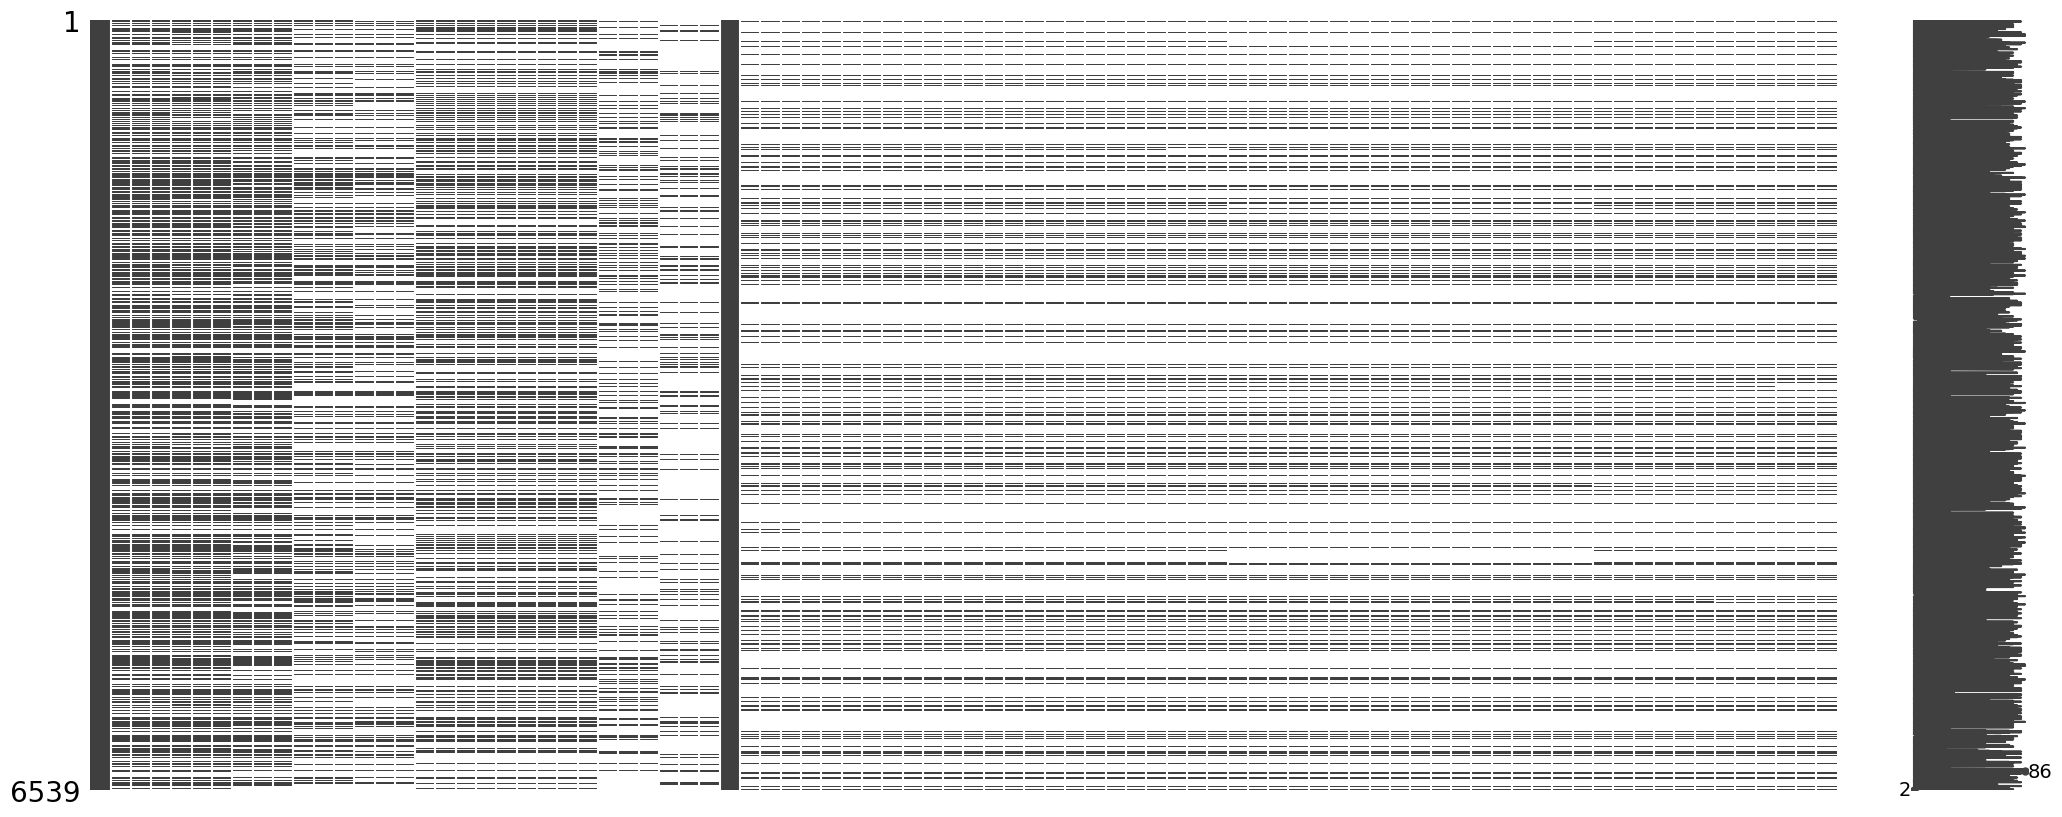

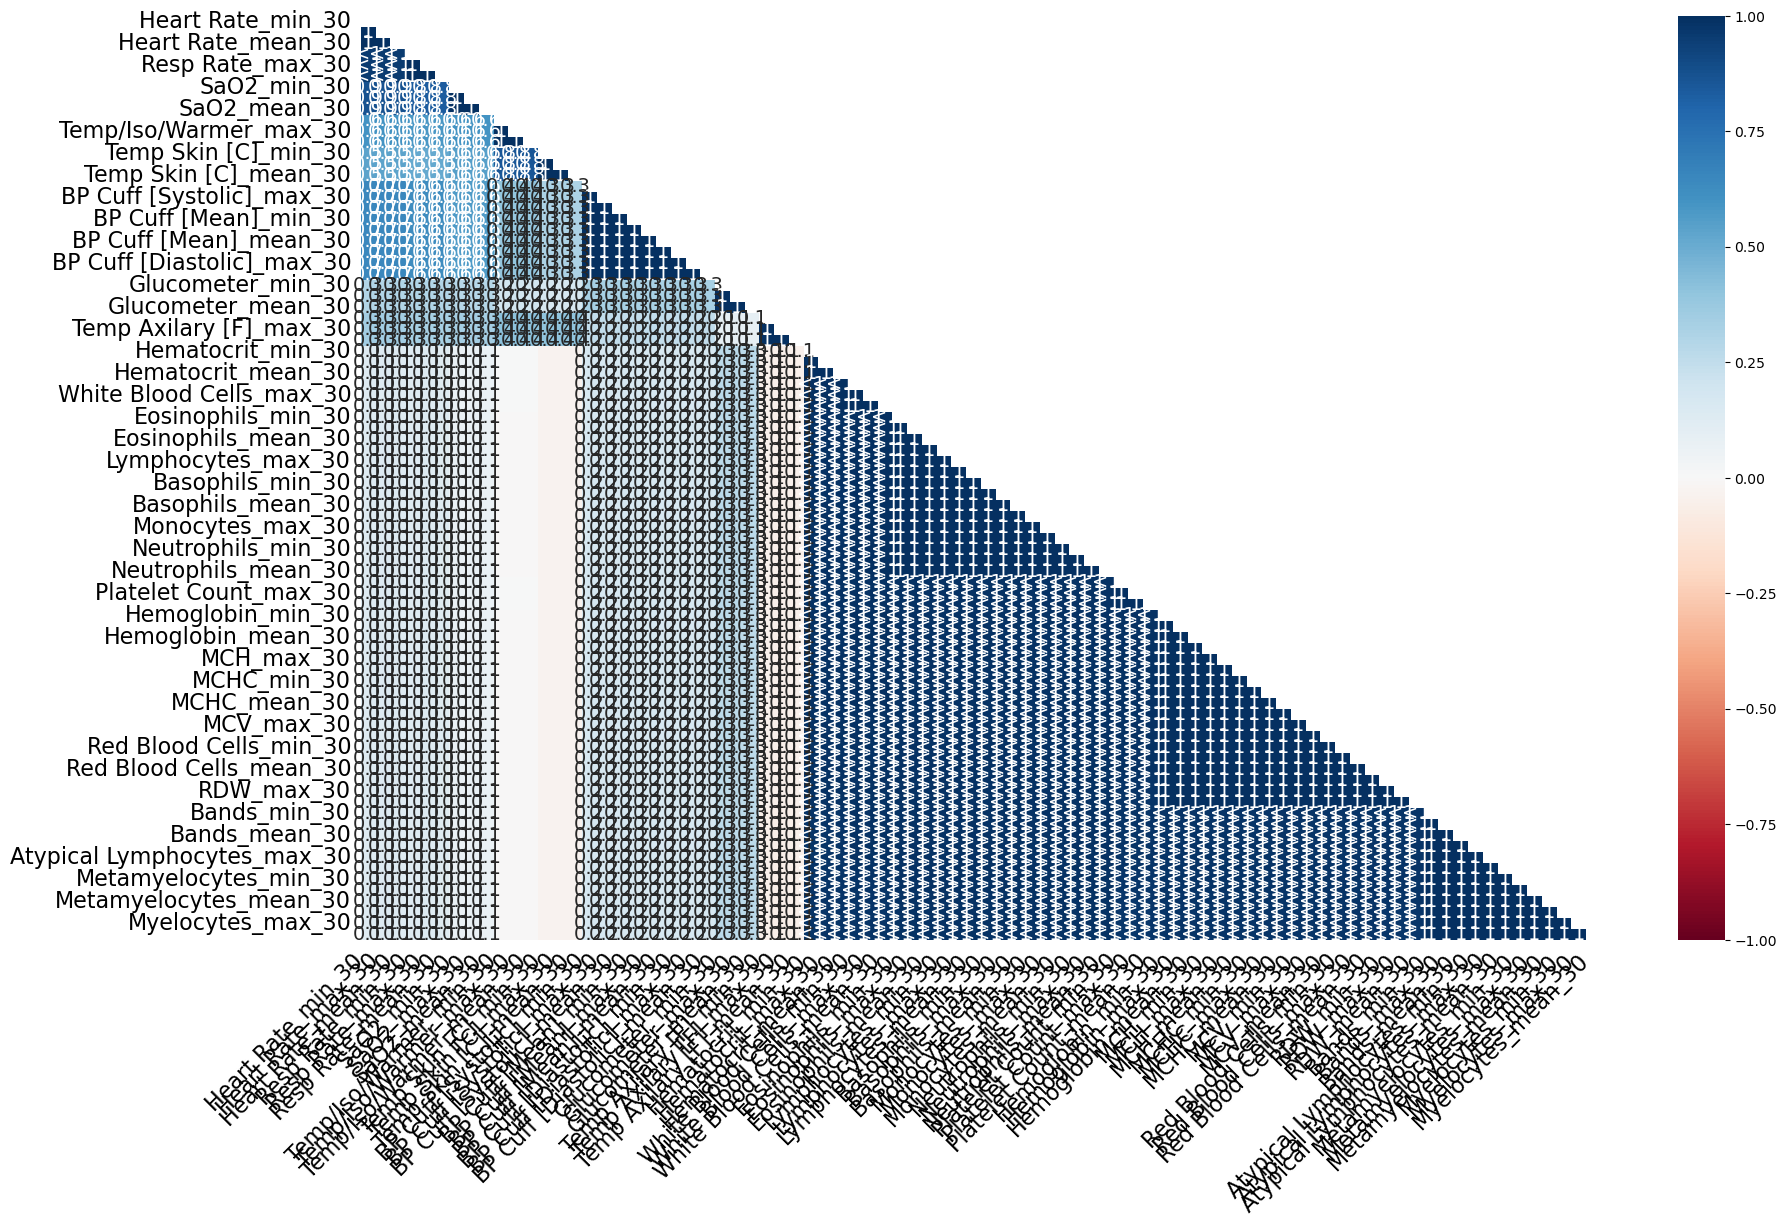

In [3]:
df = pd.read_csv("../data/final/nicu_30.csv")

# 删除包含 "min_120" 或 "max_120" 的列
df = df.drop(columns=[col for col in df.columns if "min_120" in col or "max_120" in col])
# Run the detection function
detect_missing_data_type(df)